In [1]:
# Viz some PILRs and avg. PILRs for illustrating how correlations are computed

In [2]:
!pwd
!date

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureMorphingExt
Mon Jun 27 22:28:09 PDT 2022


In [3]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage, writers
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [4]:
# Controller form cvapipe_analysis
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
control = controller.Controller(general.load_config_file(path_config))
print(control.get_staging())

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [5]:
device = io.LocalStagingIO(control)
df = device.load_step_manifest("preprocessing")
print(df.shape)

(202847, 1290)


In [6]:
genes = {"HIST1H2BJ": 640862, "ST6GAL1": 438826, "TOMM20": 230883, "SLC25A17": 838229, "LMNB1": 293584, "FBL": 698588}

In [8]:
instances = {}
for gene, CellId in genes.items():
    row = df.loc[CellId]
    print(gene, CellId)
    producer = io.DataProducer(control)
    producer.set_row(row)
    producer.load_single_cell_data()
    producer.align_data()
    instances[gene] = {"CellId": CellId, "data": producer.data_aligned.copy()}

HIST1H2BJ 640862
ST6GAL1 438826
TOMM20 230883
SLC25A17 838229
LMNB1 293584
FBL 698588


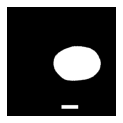

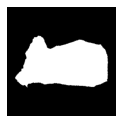

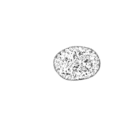

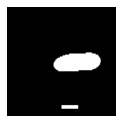

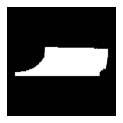

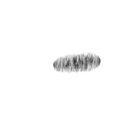

HIST1H2BJ: 725.0-2858.0


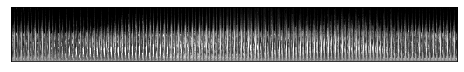

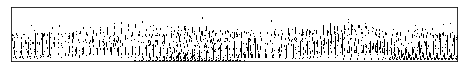

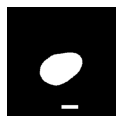

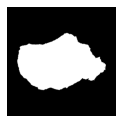

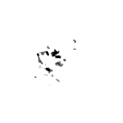

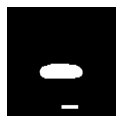

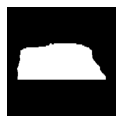

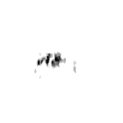

ST6GAL1: 403.0-469.0


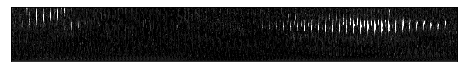

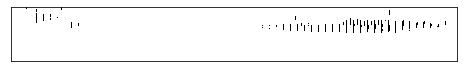

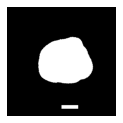

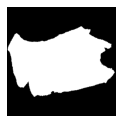

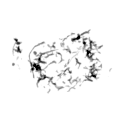

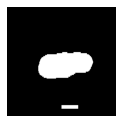

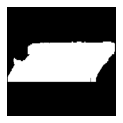

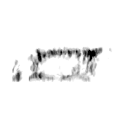

TOMM20: 413.0-537.0


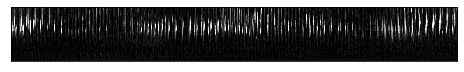

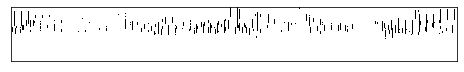

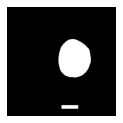

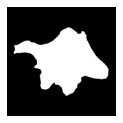

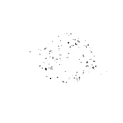

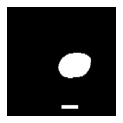

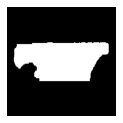

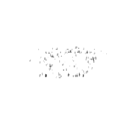

SLC25A17: 403.0-428.0


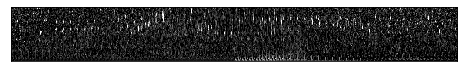

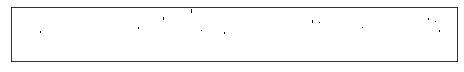

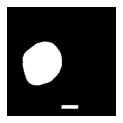

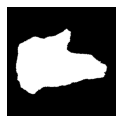

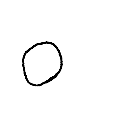

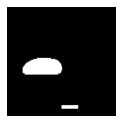

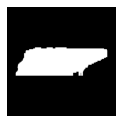

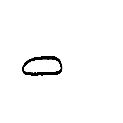

LMNB1: 493.0-1163.0


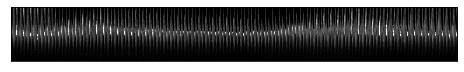

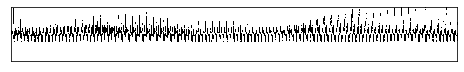

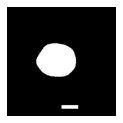

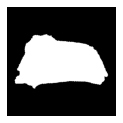

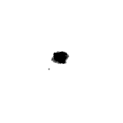

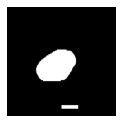

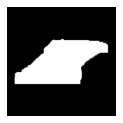

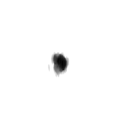

FBL: 461.0-3123.0


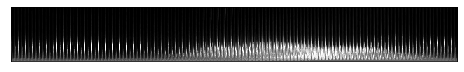

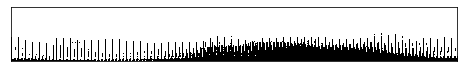

In [11]:
for gene, idata in instances.items():
    
    instance = idata["data"][[3, 5, 2, 7]]
    for plane in ["z", "y"]:
        proj = common.Projector(instance[[0,1,3]], box_size=300, mask_on=True)
        mode = {"nuc": "max","mem": "max","gfp": "mean"}
        if gene in ["LMNB1"]:
            mode["gfp"] = "center_nuc"
        proj.set_projection_mode(ax=plane, mode=mode)
        vmin, vmax = control.get_optimal_seg_contrast(gene)
        proj.set_vmin_vmax_gfp_values(vmin, vmax)
        proj.set_gfp_colormap("binary")
        proj.project(save=f"FigureMorphingExt1_{gene}_cell_{plane}", scale_bar={"pixel_size":0.108, "length":5})

    nuc = (instance[0]>0).astype(np.uint8)
    mem = (instance[1]>0).astype(np.uint8)

    niso = control.get_number_of_interpolating_points()
    coords_param, coeffs_centroid = cytoparam.parameterize_image_coordinates(
        seg_mem=mem,
        seg_nuc=nuc,
        lmax=control.get_lmax(),
        nisos=[niso, niso]
    )
    coeffs_mem, centroid_mem, coeffs_nuc, centroid_nuc = coeffs_centroid

    rep = cytoparam.parameterization_from_shcoeffs(
        coeffs_mem=coeffs_mem,
        centroid_mem=centroid_mem,
        coeffs_nuc=coeffs_nuc,
        centroid_nuc=centroid_nuc,
        nisos=[niso, niso],
        images_to_probe=[("gfp", instance[-2]), ("seg", instance[-1])]
    ).data.squeeze()

    vmin, vmax = np.percentile(rep[0].flatten(), [20, 99.5])
    print(f"{gene}: {vmin:.1f}-{vmax:.1f}")

    fig, ax = plt.subplots(1,1, figsize=(8,1))
    ax.imshow(rep[0], cmap="gray", origin="lower", interpolation="nearest", aspect="auto", vmin=vmin, vmax=vmax)
    ax.set_xticks([]); ax.set_yticks([])
    plt.savefig(f"FigureMorphingExt1_{gene}_rep_gfp.png", dpi=150)
    plt.show()

    fig, ax = plt.subplots(1,1, figsize=(8,1))
    ax.imshow(rep[1], cmap="binary", origin="lower", interpolation="nearest", aspect="auto")
    ax.set_xticks([]); ax.set_yticks([])
    plt.savefig(f"FigureMorphingExt1_{gene}_rep_seg.png", dpi=150)
    plt.show()